In [2]:
from data_processing import SDTDataset, GradientDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2 as transformsv2
from torch.utils.data import DataLoader
import torch
import numpy as np
from model import UNet
from instance_seg import salt_and_pepper_noise, gaussian_noise
import skimage.io as skio
from skimage.color import label2rgb as label
from skimage.filters import gaussian
import skimage.morphology as skm
import skimage.measure as skme
from PIL import Image
import tifffile

In [3]:
# load model from checkpoint
modelpath = '/localscratch/dl4mia-project-segmentation/logs/model.pth'
model = UNet(
        depth=4,
        in_channels=1,
        out_channels=1,
        final_activation="Sigmoid",
        num_fmaps=16,
        fmap_inc_factor=2,
        downsample_factor=2,
        padding="same",
        upsample_mode="nearest",
    )
checkpoint = torch.load(modelpath)
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cuda')
model.eval()

UNet(
  (left_convs): ModuleList(
    (0): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 12

In [5]:
train_data = GradientDataset(transform=None, img_transform=None, train=True, center_crop=True, pad=256)
val_data = GradientDataset(train=False, mean=train_data.mean, std=train_data.std, center_crop=True, pad=256)

In [6]:
im_path = "/group/dl4miacourse/projects/membrane/ecad_gfp/20240408_embryo_1/max_project_NG-ILE-C488-mp.tif"
mask_path = "/group/dl4miacourse/projects/membrane/ecad_gfp/20240408_embryo_1/cell_mesh_mask.tif"

im = tifffile.imread(im_path)[10]
mask = tifffile.imread(mask_path)[10]
im = Image.fromarray(im)
mask = Image.fromarray(mask)

inp_transforms = transforms.Compose(
            [
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize([train_data.mean], [train_data.std]),  # 0.5 = mean and 0.5 = variance
            ]
        )
image = inp_transforms(im)

In [7]:
#retrieve image
idx = 10
image, mask = val_data[idx]
mask = np.squeeze(mask.cpu())

In [7]:
image = image.to('cuda')
print(image.shape)
# generate prediction from neural network
with torch.no_grad():
    pred = model(image[np.newaxis, ...])

image = np.squeeze(image.cpu())
gt_labels = mask
pred = np.squeeze(pred.cpu().detach().numpy())

torch.Size([1, 1200, 1200])


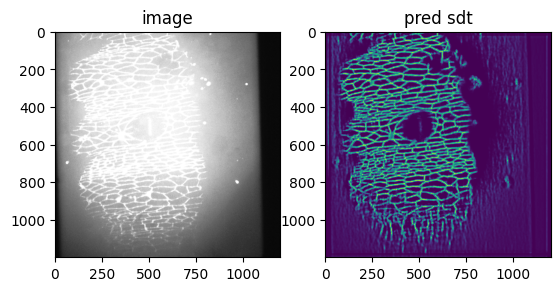

In [8]:
#visualize the outputs
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(pred, cmap='viridis')
ax[1].set_title('pred sdt')
plt.show()

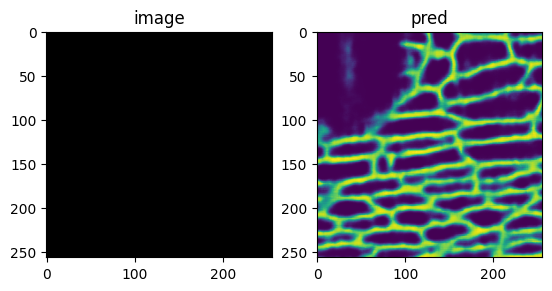

In [11]:
#visualize the outputs
fig, ax = plt.subplots(1, 2)
cropped_img = transforms.CenterCrop(256)(Image.fromarray(image.numpy()))
cropped_pred = transforms.CenterCrop(256)(transforms.ToTensor()(pred))
ax[0].imshow(cropped_img, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(cropped_pred.numpy()[0], cmap='viridis')
ax[1].set_title('pred')
plt.show()

In [10]:
# perform a watershed on the predicted sdt mask
from model_evaluation import watershed_from_boundary_distance, get_inner_mask
from skimage.filters import threshold_otsu

# Do watershed and compare to gt mask
threshold = threshold_otsu(pred)

# Get inner mask
inner_mask = get_inner_mask(pred, threshold=threshold)

# Get the segmentation
seg = watershed_from_boundary_distance(1 - pred, 1 - inner_mask, min_seed_distance=20)
seg = skm.binary_dilation(seg > 0, skm.disk(1))
seg = skme.label(seg)
new_seg = np.zeros(seg.shape)
for this_region in np.unique(seg):
    if this_region == 0:
        continue
    region_mask = seg == this_region
    region_mask = skm.binary_dilation(region_mask, skm.disk(3))
    new_seg = np.where(region_mask, this_region, new_seg)
seg = new_seg * (np.array(gt_labels) > 0)


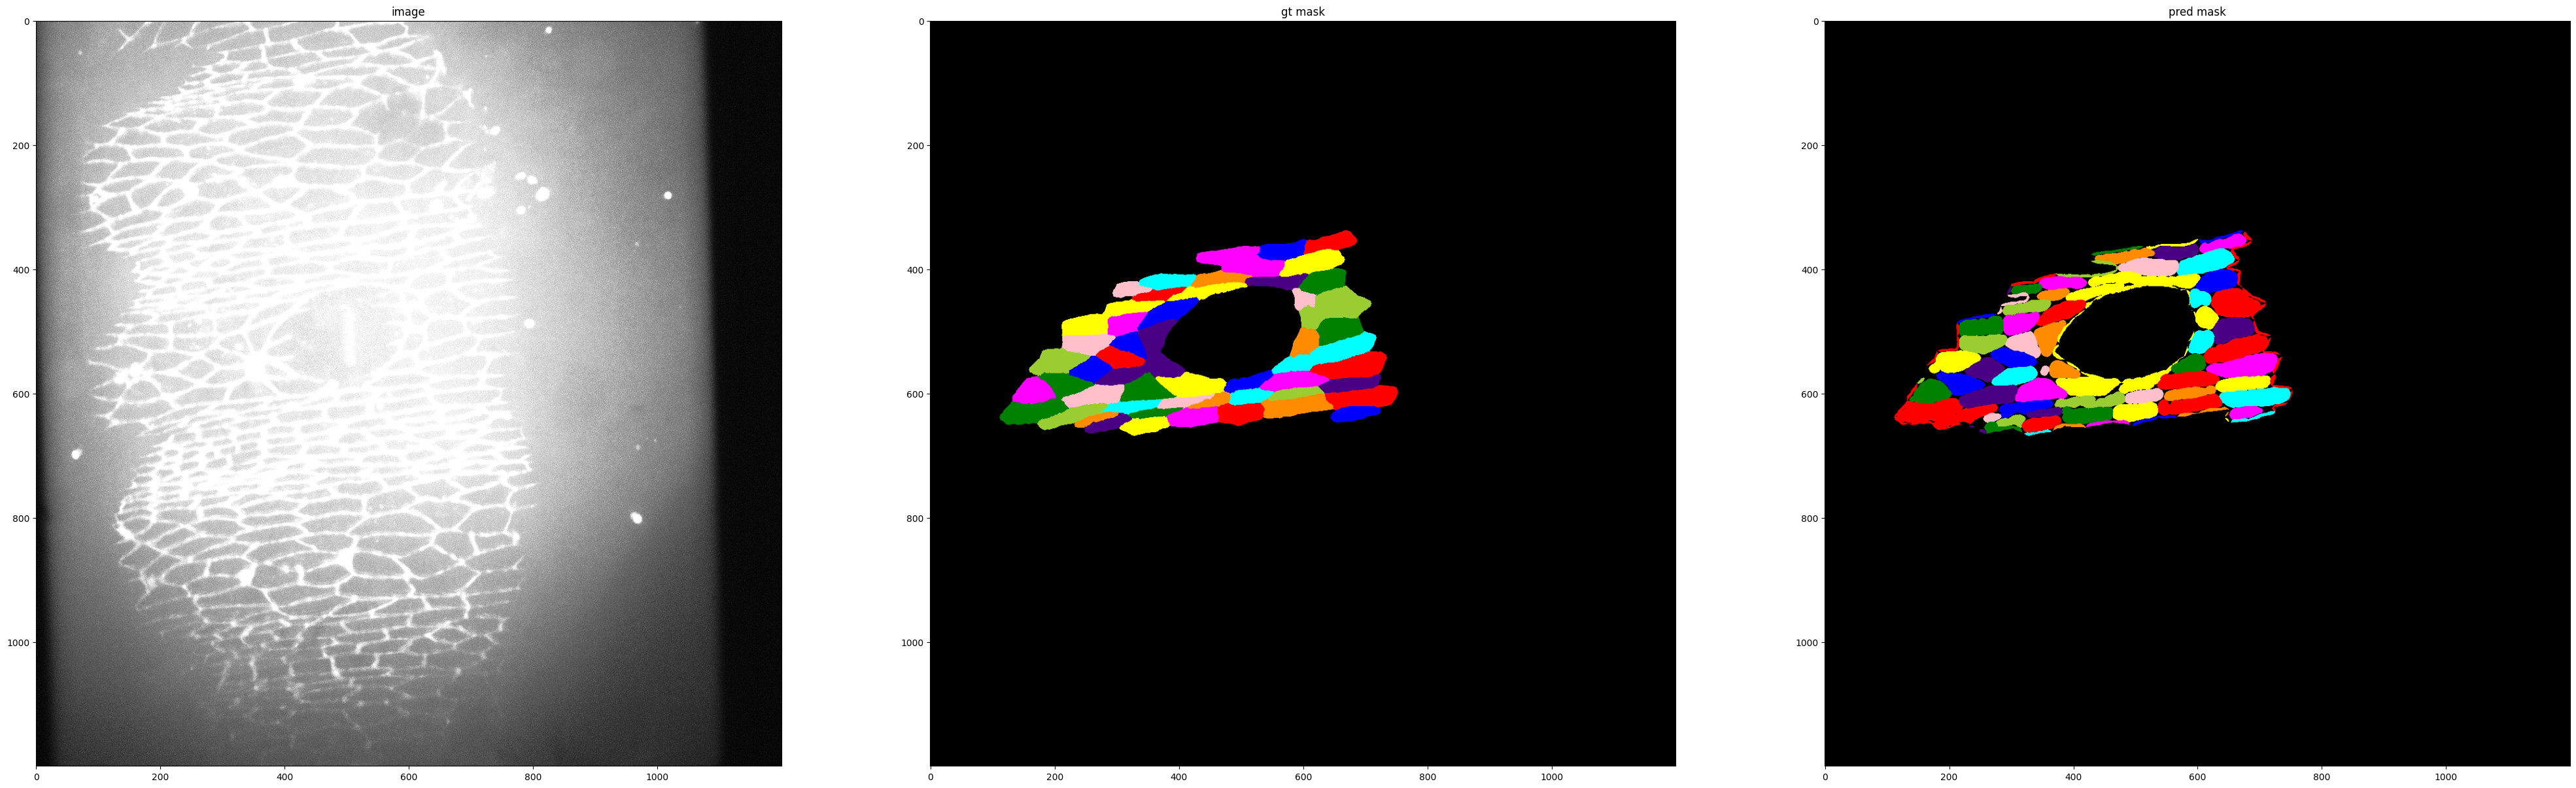

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
#visualize the outputs
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(50, 50))
# cropped_seg = transforms.CenterCrop(256)(Image.fromarray(seg))
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(label(np.array(gt_labels)))  #, cmap='tab10')
ax[1].set_title('gt mask')
ax[2].imshow(label(seg)) # cmap='tab10')
ax[2].set_title('pred mask')
plt.savefig('/group/dl4miacourse/projects/membrane/FinalPresentation/gradient_whole_img_mask.png')
plt.show()
print(seg)

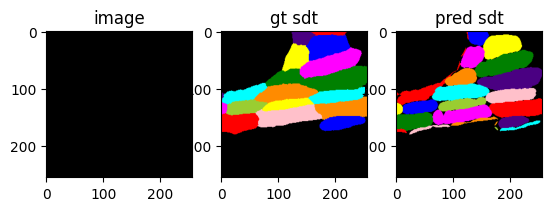

In [71]:
#visualize the outputs
fig, ax = plt.subplots(1, 3)
cropped_img = transforms.CenterCrop(256)(Image.fromarray(image.numpy()))
cropped_seg = transforms.CenterCrop(256)(transforms.ToTensor()(seg))
cropped_gt = transforms.CenterCrop(256)(transforms.ToTensor()(gt_labels))
ax[0].imshow(cropped_img, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(label(cropped_gt.numpy()[0]))
ax[1].set_title('gt sdt')
ax[2].imshow(label(cropped_seg.numpy()[0]))
ax[2].set_title('pred sdt')
plt.show()

In [72]:
# get some metrics to compare
from model_evaluation import evaluate
from sklearn.metrics import mean_squared_error
metrics = dict()
metrics['precision_list'], metrics['recall_list'], metrics['accuracy_list'], metrics['iou_list'], metrics['mse_list'] = [], [], [], [], []
precision, recall, accuracy, iou = evaluate(np.array(gt_labels).astype(np.uint16), seg.astype(np.uint16))
metrics['precision_list'].append(precision)
metrics['recall_list'].append(recall)
metrics['accuracy_list'].append(accuracy)
metrics['iou_list'].append(iou)
print(metrics['precision_list'])

[0.6567164179104478]


In [60]:
print(f"Precision: {metrics['precision_list'][0]}")
print(f"Recall: {metrics['recall_list'][0]}")
print(f"Accuracy: {metrics['accuracy_list'][0]}")
print(f"Mean IOU: {np.mean(metrics['iou_list'])}")
print(f"Mean TP IOU: {np.mean(metrics['iou_list'][0][metrics['iou_list'][0] > 0.5])}")

Precision: 0.6470588235294118
Recall: 0.7857142857142857
Accuracy: 0.55
Mean IOU: 0.5613067746162415
Mean TP IOU: 0.7775218486785889
